In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import keras

In [4]:
# Import model
model = keras.models.load_model("/content/drive/MyDrive/Pressure Sensor Maching Learning/Models/timeseries_model6_iter2.keras")

In [13]:
def load_df(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File path '{filepath}' does not exist.")
    try:
        return pd.read_pickle(filepath)
    except Exception as e:
        print(f"Failed to load dataframe from {filepath}: {e}")
        return None

True


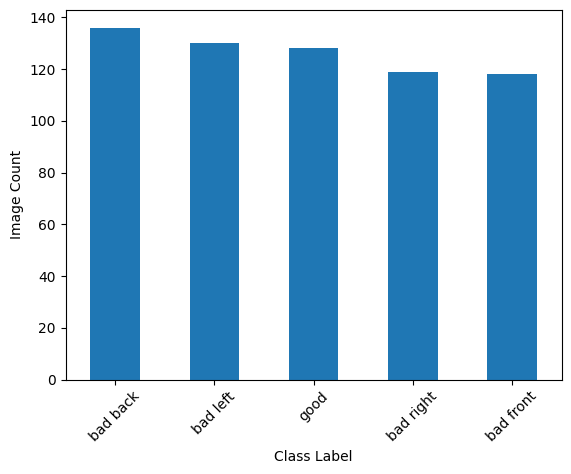

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
# Load df from pickle file
filepath = '/content/drive/MyDrive/Pressure Sensor Maching Learning/Current Data/timeseries_df_3point3.pkl'
print(os.path.exists(filepath))
combined_timeseries_df = load_df(filepath)
combined_timeseries_df.Label.value_counts().plot(kind='bar')
# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.xlabel("Class Label")

# Show the plot
plt.show()

In [18]:
print("Expected input shape:", model.input.shape)  # Shows input shape
print("Expected input dtype:", model.input.dtype)  # Shows input data type
print(X_train[0].shape)
ex = np.expand_dims(X_train[0], axis = (-1))
print(ex.shape)

Expected input shape: (None, 8, 500, 1)
Expected input dtype: <dtype: 'float32'>
(8, 500)
(8, 500, 1)


In [21]:
# Convert the model for partial int/float
#NOTE arena (intermediate tensors) are to big for model6 when doing float16 (>6 MB) and edgeimpulse/TF micro does not support hybrid int and float operations. Must do full int quant
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # converter.target_spec.supported_types = [tf.float16]
# tflite_model = converter.convert()

# Full Int Quant
# Sample representative dataset function using a subset of training images
def representative_dataset():
    for image in X_train[:100]:  # Use 100 images or an appropriate subset
        image = np.expand_dims(image, axis=(0, -1)).astype(np.float32)  # Ensure correct shape (1, 8, 500, 1) if needed
        yield [image]

# Convert the model with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset

# Convert the model
tflite_model = converter.convert()
# Save the model.
with open("/content/drive/MyDrive/Pressure Sensor Maching Learning/Models/model6_8bit_int.tflite", 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [22]:
tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #19 as output.

Subgraph#0 main(T#0) -> [T#33]
  Op#0 QUANTIZE(T#0) -> [T#19]
  Op#1 SPACE_TO_BATCH_ND(T#19, T#1[1, 2], T#2[3, 4, 14, 14]) -> [T#20]
  Op#2 CONV_2D(T#20, T#18, T#17[0, 0, 0, 0, 0, ...]) -> [T#21]
  Op#3 BATCH_TO_SPACE_ND(T#21, T#1[1, 2], T#3[0, 0, 0, 0]) -> [T#22]
  Op#4 ADD(T#22, T#16) -> [T#23]
  Op#5 CONV_2D(T#23, T#15, T#14[18165, -9994, -2920, 39698, -4706, ...]) -> [T#24]
  Op#6 SPACE_TO_BATCH_ND(T#24, T#1[1, 2], T#4[3, 4, 4, 5]) -> [T#25]
  Op#7 CONV_2D(T#25, T#13, T#12[0, 0, 0, 0, 0, ...]) -> [T#26]
  Op#8 BATCH_TO_SPACE_ND(T#26, T#1[1, 2], T#5[0, 0, 0, 1]) -> [T#27]
  Op#9 ADD(T#27, T#11) -> [T#28]
  Op#10 CONV_2D(T#28, T#10, T#9[-24, 1408, -1102, -2788, -1796, ...]) -> [T#29]
  Op#11 RESHAPE(T#29, T#6[-1, 7936]) -> [T#30]
  Op#12 FULLY_C

In [17]:
print(model.summary())

Model: "dilated"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8, 500, 1)]       0         
                                                                 
 dilated_conv1 (Conv2D)      (None, 8, 500, 32)        3872      
                                                                 
 strided_conv1 (Conv2D)      (None, 8, 125, 32)        4128      
                                                                 
 dilated_conv2 (Conv2D)      (None, 8, 125, 16)        20496     
                                                                 
 strided_conv2 (Conv2D)      (None, 8, 62, 16)         784       
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dropout (Dropout)           (None, 7936)              0   

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
X = np.array(combined_timeseries_df['Image'].tolist())
Y = combined_timeseries_df["Label"]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)
labels_categorical = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, labels_categorical, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (504, 8, 500)
y_train shape: (504, 5)
X_test shape: (127, 8, 500)
y_test shape: (127, 5)


In [24]:
print("Labels and their integer encodings:", label_encoder.classes_)

Labels and their integer encodings: ['bad back' 'bad front' 'bad left' 'bad right' 'good']


In [25]:
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Pressure Sensor Maching Learning/Models/model6_8bit_int.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1,   8, 500,   1], dtype=int32), 'shape_signature': array([ -1,   8, 500,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 33, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [26]:
print(X_test.shape)
modified_img = np.expand_dims(X_test[0], axis = (0,-1))
print(modified_img.shape)

(127, 8, 500)
(1, 8, 500, 1)


In [27]:
# Loop through X_test (which contains your test images)
predicted_classes = []
true_classes = []
for i in range(len(X_test)):
    # Prepare input data
    input_data = np.expand_dims(X_test[i], axis = (0,-1)).astype(np.float32)  # Ensure correct shape and data type

    # Set the input tensor (place the test image into the model)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor (predictions)
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # You can add code to process or display the output, for example:
    predicted_classes.append(np.argmax(output_data))
    true_classes.append(np.argmax(y_test[i]))
    interpreter.reset_all_variables()
num_correct = 0
for idx, prediction in enumerate(predicted_classes):
  if prediction == true_classes[idx]:
    num_correct += 1
print("acccuracy is ", num_correct/len(predicted_classes))
print("total count is ", len(predicted_classes))
print("num correct is ", num_correct)


acccuracy is  0.7952755905511811
total count is  127
num correct is  101


Classification Report:
              precision    recall  f1-score   support

    bad back       0.66      0.73      0.69        26
   bad front       1.00      1.00      1.00        23
    bad left       1.00      0.81      0.90        27
   bad right       0.58      0.54      0.56        26
        good       0.79      0.92      0.85        25

    accuracy                           0.80       127
   macro avg       0.81      0.80      0.80       127
weighted avg       0.80      0.80      0.80       127



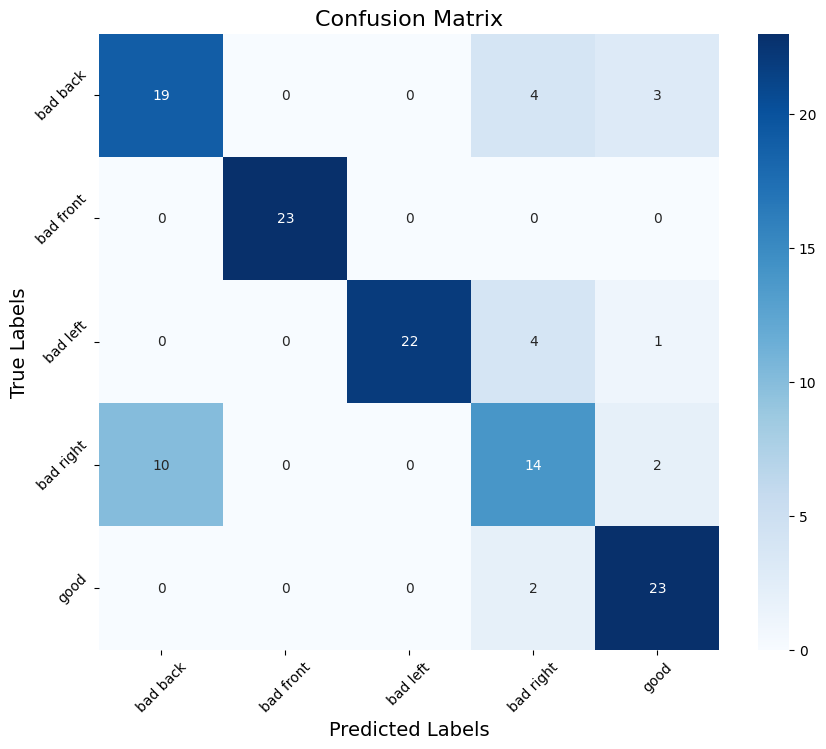

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Creating the classification report and confusion matrix
labels = label_encoder.classes_
confusion = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=labels)

# Print classification report
print("Classification Report:")
print(report)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Adding labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Rotate the x and y labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Save the model.
with open("/content/drive/MyDrive/Pressure Sensor Maching Learning/Models/timeseries_quantized_model4_2point2", 'wb') as f:
  f.write(tflite_model)

In [30]:
raw_img = [0.028571429, 0.035714287, 0.03214286, 0.03214286, 0.03214286, 0.03214286, 0.03214286, 0.028571429,
    0.021428572, 0.021428572, 0.014285714, 0.014285714, 0.007142857, 0.007142857, 0.007142857, 0.007142857,
    0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    0.0035714286, 0.0, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.007142857,
    0.007142857, 0.007142857, 0.007142857, 0.014285714, 0.010714286, 0.017857144, 0.014285714, 0.021428572,
    0.025, 0.028571429, 0.03214286, 0.035714287, 0.03214286, 0.035714287, 0.035714287, 0.03214286,
    0.03214286, 0.03214286, 0.03214286, 0.028571429, 0.025, 0.021428572, 0.017857144, 0.017857144,
    0.010714286, 0.010714286, 0.010714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.0, 0.0, 0.0, 0.007142857, 0.0, 0.007142857, 0.0035714286, 0.007142857,
    0.007142857, 0.014285714, 0.010714286, 0.021428572, 0.017857144, 0.025, 0.025, 0.028571429,
    0.028571429, 0.035714287, 0.03214286, 0.035714287, 0.035714287, 0.035714287, 0.028571429, 0.03214286,
    0.017857144, 0.017857144, 0.017857144, 0.010714286, 0.010714286, 0.010714286, 0.007142857, 0.010714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286,
    0.007142857, 0.0035714286, 0.0035714286, 0.007142857, 0.014285714, 0.010714286, 0.014285714, 0.017857144,
    0.017857144, 0.025, 0.03214286, 0.028571429, 0.028571429, 0.028571429, 0.03214286, 0.028571429,
    0.035714287, 0.03214286, 0.03214286, 0.03214286, 0.028571429, 0.021428572, 0.017857144, 0.014285714,
    0.014285714, 0.010714286, 0.010714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0035714286, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.007142857, 0.007142857, 0.007142857,
    0.010714286, 0.010714286, 0.014285714, 0.014285714, 0.021428572, 0.021428572, 0.028571429, 0.03214286,
    0.028571429, 0.028571429, 0.03214286, 0.035714287, 0.03214286, 0.03214286, 0.03214286, 0.03214286,
    0.028571429, 0.021428572, 0.021428572, 0.014285714, 0.010714286, 0.010714286, 0.010714286, 0.010714286,
    0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.010714286, 0.010714286, 0.014285714, 0.014285714,
    0.014285714, 0.014285714, 0.010714286, 0.014285714, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.007142857, 0.010714286, 0.014285714, 0.014285714,
    0.017857144, 0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.017857144, 0.017857144, 0.010714286,
    0.010714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286,
    0.0, 0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, 0.0, 0.007142857,
    0.0035714286, 0.010714286, 0.007142857, 0.017857144, 0.010714286, 0.021428572, 0.014285714, 0.017857144,
    0.014285714, 0.017857144, 0.010714286, 0.014285714, 0.0035714286, 0.010714286, 0.0, 0.0035714286,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.007142857, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.007142857, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0035714286, 0.007142857, 0.007142857, 0.010714286, 0.010714286,
    0.010714286, 0.010714286, 0.014285714, 0.014285714, 0.014285714, 0.014285714, 0.014285714, 0.014285714,
    0.010714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.007142857,
    0.0, -0.007142857, 0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0, -0.007142857, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.007142857,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.007142857, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0035714286,
    0.0035714286, 0.007142857, 0.007142857, 0.010714286, 0.014285714, 0.010714286, 0.014285714, 0.017857144,
    0.014285714, 0.014285714, 0.010714286, 0.010714286, 0.010714286, 0.0035714286, 0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286,
    0.08571429, 0.08571429, 0.08928572, 0.08928572, 0.08928572, 0.08928572, 0.08928572, 0.08214286,
    0.075, 0.067857146, 0.06428572, 0.06428572, 0.060714286, 0.05357143, 0.05357143, 0.046428572,
    0.046428572, 0.042857144, 0.042857144, 0.042857144, 0.042857144, 0.039285716, 0.035714287, 0.035714287,
    0.035714287, 0.035714287, 0.035714287, 0.03214286, 0.03214286, 0.028571429, 0.028571429, 0.025,
    0.028571429, 0.028571429, 0.021428572, 0.025, 0.025, 0.021428572, 0.021428572, 0.021428572,
    0.017857144, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.017857144, 0.014285714,
    0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.017857144, 0.017857144, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.017857144, 0.021428572, 0.014285714, 0.017857144, 0.021428572, 0.021428572,
    0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.021428572, 0.017857144, 0.021428572,
    0.021428572, 0.021428572, 0.025, 0.025, 0.025, 0.025, 0.025, 0.03214286,
    0.03214286, 0.03214286, 0.035714287, 0.035714287, 0.039285716, 0.042857144, 0.042857144, 0.046428572,
    0.05, 0.05357143, 0.060714286, 0.057142857, 0.057142857, 0.06428572, 0.075, 0.075,
    0.08214286, 0.08571429, 0.08928572, 0.08928572, 0.08928572, 0.092857145, 0.08928572, 0.08928572,
    0.092857145, 0.08928572, 0.092857145, 0.08571429, 0.07857143, 0.071428575, 0.067857146, 0.06428572,
    0.060714286, 0.05357143, 0.05357143, 0.05, 0.046428572, 0.042857144, 0.042857144, 0.042857144,
    0.039285716, 0.035714287, 0.035714287, 0.03214286, 0.035714287, 0.03214286, 0.03214286, 0.028571429,
    0.028571429, 0.028571429, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
    0.025, 0.025, 0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.017857144, 0.021428572, 0.021428572, 0.017857144, 0.017857144, 0.021428572,
    0.014285714, 0.021428572, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.017857144, 0.021428572, 0.017857144, 0.017857144, 0.017857144, 0.021428572,
    0.017857144, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.025,
    0.017857144, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.025, 0.025, 0.025,
    0.025, 0.028571429, 0.028571429, 0.03214286, 0.03214286, 0.03214286, 0.03214286, 0.035714287,
    0.039285716, 0.039285716, 0.039285716, 0.042857144, 0.046428572, 0.05, 0.05357143, 0.057142857,
    0.06428572, 0.06428572, 0.067857146, 0.071428575, 0.075, 0.08571429, 0.08928572, 0.092857145,
    0.08928572, 0.08928572, 0.092857145, 0.08928572, 0.08928572, 0.092857145, 0.08928572, 0.08928572,
    0.07857143, 0.07857143, 0.067857146, 0.067857146, 0.060714286, 0.057142857, 0.05, 0.05357143,
    0.046428572, 0.05, 0.042857144, 0.042857144, 0.039285716, 0.039285716, 0.035714287, 0.039285716,
    0.03214286, 0.035714287, 0.028571429, 0.035714287, 0.028571429, 0.03214286, 0.028571429, 0.028571429,
    0.021428572, 0.025, 0.021428572, 0.021428572, 0.021428572, 0.025, 0.021428572, 0.021428572,
    0.017857144, 0.017857144, 0.017857144, 0.021428572, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.014285714, 0.021428572, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.014285714, 0.017857144,
    0.017857144, 0.021428572, 0.014285714, 0.014285714, 0.017857144, 0.017857144, 0.017857144, 0.021428572,
    0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.014285714, 0.017857144, 0.014285714, 0.017857144,
    0.017857144, 0.021428572, 0.014285714, 0.017857144, 0.017857144, 0.017857144, 0.014285714, 0.021428572,
    0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.021428572, 0.021428572, 0.021428572, 0.025, 0.025, 0.025, 0.028571429, 0.028571429,
    0.028571429, 0.03214286, 0.035714287, 0.035714287, 0.039285716, 0.042857144, 0.042857144, 0.042857144,
    0.046428572, 0.05, 0.05357143, 0.057142857, 0.060714286, 0.060714286, 0.067857146, 0.067857146,
    0.075, 0.08214286, 0.08571429, 0.08928572, 0.08928572, 0.092857145, 0.092857145, 0.092857145,
    0.09642857, 0.09642857, 0.092857145, 0.08928572, 0.07857143, 0.075, 0.071428575, 0.067857146,
    0.060714286, 0.057142857, 0.05357143, 0.05, 0.05, 0.05, 0.046428572, 0.042857144,
    0.042857144, 0.042857144, 0.039285716, 0.039285716, 0.039285716, 0.035714287, 0.035714287, 0.03214286,
    0.03214286, 0.03214286, 0.028571429, 0.025, 0.025, 0.025, 0.025, 0.028571429,
    0.025, 0.025, 0.025, 0.021428572, 0.025, 0.021428572, 0.021428572, 0.021428572,
    0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.021428572, 0.021428572,
    0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.021428572, 0.021428572,
    0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.017857144, 0.017857144, 0.021428572, 0.017857144,
    0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.021428572, 0.021428572, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144,
    0.021428572, 0.014285714, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.025, 0.021428572,
    0.028571429, 0.025, 0.028571429, 0.028571429, 0.03214286, 0.028571429, 0.035714287, 0.035714287,
    0.039285716, 0.039285716, 0.039285716, 0.039285716, 0.05, 0.05, 0.057142857, 0.057142857,
    0.060714286, 0.060714286, 0.067857146, 0.071428575, 0.075, 0.07857143, 0.08928572, 0.092857145,
    0.092857145, 0.08928572, 0.09642857, 0.092857145, 0.09642857, 0.09642857, 0.09642857, 0.092857145,
    0.08571429, 0.07857143, 0.07857143, 0.071428575, 0.06428572, 0.057142857, 0.057142857, 0.05357143,
    0.05, 0.05, 0.046428572, 0.046428572, 0.046428572, 0.042857144, 0.039285716, 0.035714287,
    0.039285716, 0.035714287, 0.03214286, 0.03214286, 0.03214286, 0.03214286, 0.03214286, 0.03214286,
    0.028571429, 0.025, 0.025, 0.025, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.007142857, -0.0035714286, -0.007142857, 0.0, -0.0035714286,
    -0.0035714286, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.007142857,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, 0.0035714286, -0.007142857, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.010714286, 0.0, -0.0035714286, 0.0, -0.007142857,
    0.0, -0.007142857, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, 0.0, -0.0035714286, 0.0, -0.007142857,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    -0.0035714286, 0.007142857, 0.0, 0.007142857, 0.0, 0.0035714286, 0.0, 0.007142857,
    0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.007142857, 0.007142857,
    0.007142857, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, -0.007142857, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286,
    -0.0035714286, 0.0, -0.007142857, 0.0035714286, -0.007142857, 0.0035714286, -0.007142857, 0.007142857,
    -0.007142857, -0.0035714286, -0.007142857, 0.0, -0.007142857, 0.0, -0.007142857, 0.0035714286,
    -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.007142857, 0.0, -0.0035714286, 0.0,
    -0.007142857, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.007142857, 0.0,
    -0.007142857, 0.0, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.007142857, 0.0, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, -0.007142857, 0.0, -0.007142857,
    0.0035714286, -0.007142857, 0.007142857, -0.007142857, 0.0035714286, -0.007142857, 0.007142857, -0.007142857,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.007142857, 0.0035714286, -0.0035714286,
    0.0035714286, -0.0035714286, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.021428572, 0.021428572, 0.025, 0.021428572, 0.021428572, 0.021428572, 0.021428572, 0.017857144,
    0.021428572, 0.014285714, 0.017857144, 0.014285714, 0.017857144, 0.014285714, 0.014285714, 0.007142857,
    0.014285714, 0.010714286, 0.010714286, 0.0035714286, 0.010714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286,
    0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.0,
    0.007142857, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, -0.0035714286, 0.007142857, 0.0,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.007142857, 0.0, 0.007142857, 0.0035714286,
    0.0, 0.0035714286, 0.0035714286, 0.0, 0.007142857, 0.0, 0.007142857, -0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, -0.0035714286, 0.007142857, 0.0,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0,
    0.0035714286, -0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0,
    0.007142857, 0.0035714286, 0.014285714, 0.007142857, 0.007142857, 0.007142857, 0.014285714, 0.010714286,
    0.014285714, 0.010714286, 0.017857144, 0.010714286, 0.014285714, 0.014285714, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.025, 0.025, 0.025, 0.017857144, 0.025, 0.017857144,
    0.028571429, 0.021428572, 0.025, 0.021428572, 0.025, 0.014285714, 0.017857144, 0.014285714,
    0.017857144, 0.010714286, 0.010714286, 0.010714286, 0.014285714, 0.007142857, 0.010714286, 0.007142857,
    0.007142857, 0.0035714286, 0.010714286, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286,
    0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.010714286, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0035714286,
    0.0, 0.007142857, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286,
    0.0, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.007142857, 0.0, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0, 0.0035714286,
    0.0035714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286,
    0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.010714286,
    0.010714286, 0.014285714, 0.010714286, 0.014285714, 0.010714286, 0.017857144, 0.014285714, 0.017857144,
    0.014285714, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.025, 0.025, 0.025,
    0.021428572, 0.028571429, 0.025, 0.028571429, 0.028571429, 0.028571429, 0.021428572, 0.025,
    0.025, 0.025, 0.017857144, 0.021428572, 0.014285714, 0.021428572, 0.014285714, 0.021428572,
    0.010714286, 0.017857144, 0.010714286, 0.014285714, 0.010714286, 0.014285714, 0.010714286, 0.010714286,
    0.010714286, 0.010714286, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.007142857,
    0.0035714286, 0.010714286, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.0035714286, 0.007142857,
    0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.0, 0.007142857, 0.0035714286, 0.0035714286,
    0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286,
    0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0, 0.0035714286, 0.0, 0.007142857, 0.0, 0.007142857, 0.0, 0.007142857,
    0.0, 0.007142857, 0.0, 0.010714286, -0.0035714286, 0.007142857, -0.0035714286, 0.010714286,
    -0.0035714286, 0.014285714, -0.0035714286, 0.010714286, -0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.0, 0.007142857, -0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857,
    0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.007142857, 0.010714286, 0.010714286, 0.014285714,
    0.010714286, 0.014285714, 0.010714286, 0.017857144, 0.014285714, 0.017857144, 0.014285714, 0.021428572,
    0.017857144, 0.025, 0.025, 0.025, 0.021428572, 0.028571429, 0.021428572, 0.025,
    0.021428572, 0.025, 0.021428572, 0.025, 0.014285714, 0.021428572, 0.010714286, 0.021428572,
    0.010714286, 0.017857144, 0.007142857, 0.014285714, 0.010714286, 0.010714286, 0.007142857, 0.010714286,
    0.007142857, 0.007142857, 0.007142857, 0.010714286, 0.007142857, 0.010714286, 0.007142857, 0.007142857,
    0.0035714286, 0.007142857, 0.007142857, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.007142857,
    0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.0,
    0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.0035714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.010714286, 0.0035714286, 0.007142857, 0.0035714286, 0.010714286, 0.0035714286, 0.010714286, 0.0035714286,
    0.010714286, 0.0035714286, 0.010714286, 0.007142857, 0.007142857, 0.007142857, 0.007142857, 0.0035714286,
    0.007142857, 0.007142857, 0.010714286, 0.007142857, 0.007142857, 0.007142857, 0.010714286, 0.007142857,
    0.010714286, 0.007142857, 0.014285714, 0.010714286, 0.014285714, 0.014285714, 0.014285714, 0.014285714,
    0.014285714, 0.017857144, 0.021428572, 0.017857144, 0.025, 0.021428572, 0.028571429, 0.021428572,
    0.028571429, 0.025, 0.03214286, 0.025, 0.028571429, 0.021428572, 0.03214286, 0.021428572,
    0.025, 0.017857144, 0.021428572, 0.010714286, 0.021428572, 0.010714286, 0.014285714, 0.007142857,
    0.010714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286, 0.007142857, 0.010714286, 0.007142857,
    0.007142857, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0, 0.007142857, 0.0, 0.025, 0.021428572, 0.028571429, 0.017857144,
    0.028571429, 0.017857144, 0.025, 0.014285714, 0.017857144, 0.007142857, 0.007142857, 0.0,
    0.007142857, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0035714286, -0.007142857, 0.0, -0.007142857, 0.0, -0.0035714286, 0.0035714286, -0.007142857,
    0.0, -0.0035714286, 0.0, -0.007142857, 0.0, -0.0035714286, 0.0035714286, -0.007142857,
    0.0, -0.007142857, 0.0, -0.007142857, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0035714286, -0.007142857, 0.0, -0.007142857, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0035714286, -0.0035714286, 0.0035714286, -0.007142857, 0.0, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0035714286, -0.007142857, 0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.007142857,
    0.0, -0.007142857, 0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0,
    0.0035714286, 0.0035714286, 0.010714286, 0.010714286, 0.014285714, 0.017857144, 0.021428572, 0.021428572,
    0.025, 0.017857144, 0.025, 0.021428572, 0.025, 0.021428572, 0.021428572, 0.014285714,
    0.010714286, 0.007142857, 0.007142857, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.007142857, 0.010714286,
    0.014285714, 0.017857144, 0.021428572, 0.021428572, 0.021428572, 0.028571429, 0.025, 0.025,
    0.021428572, 0.025, 0.025, 0.017857144, 0.014285714, 0.010714286, 0.007142857, 0.0035714286,
    0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.0, 0.010714286, 0.007142857, 0.014285714, 0.010714286, 0.021428572, 0.017857144, 0.025,
    0.021428572, 0.025, 0.021428572, 0.025, 0.021428572, 0.021428572, 0.021428572, 0.017857144,
    0.010714286, 0.010714286, 0.0035714286, 0.007142857, 0.0, 0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.007142857, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.010714286, 0.010714286,
    0.014285714, 0.017857144, 0.021428572, 0.021428572, 0.021428572, 0.025, 0.025, 0.025,
    0.025, 0.025, 0.025, 0.017857144, 0.017857144, 0.010714286, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0035714286, -0.0035714286,
    0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0035714286, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.017857144, 0.014285714, 0.014285714, 0.014285714, 0.014285714, 0.014285714, 0.017857144, 0.010714286,
    0.010714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286,
    0.010714286, 0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.014285714, 0.017857144, 0.014285714,
    0.017857144, 0.014285714, 0.014285714, 0.007142857, 0.010714286, 0.0035714286, 0.007142857, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, 0.0,
    0.0035714286, 0.0, 0.0035714286, -0.0035714286, 0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.007142857, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.007142857, 0.0, -0.0035714286, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.007142857, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857, 0.007142857,
    0.0035714286, 0.0035714286, 0.007142857, 0.010714286, 0.014285714, 0.014285714, 0.017857144, 0.014285714,
    0.014285714, 0.017857144, 0.017857144, 0.014285714, 0.017857144, 0.017857144, 0.014285714, 0.010714286,
    0.010714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0035714286, 0.0, 0.0035714286,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0035714286,
    0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286,
    0.014285714, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144,
    0.014285714, 0.017857144, 0.017857144, 0.014285714, 0.010714286, 0.010714286, 0.010714286, 0.007142857,
    0.0035714286, 0.007142857, 0.0035714286, 0.007142857, 0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.0, 0.007142857, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.0, 0.0035714286,
    0.007142857, 0.010714286, 0.010714286, 0.010714286, 0.014285714, 0.017857144, 0.017857144, 0.017857144,
    0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.021428572, 0.017857144, 0.017857144, 0.017857144,
    0.014285714, 0.010714286, 0.007142857, 0.007142857, 0.010714286, 0.007142857, 0.007142857, 0.007142857,
    0.0035714286, 0.0035714286, 0.0035714286, 0.0, 0.0035714286, 0.0035714286, 0.0035714286, 0.0,
    0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, 0.014285714, 0.010714286, 0.010714286, 0.010714286,
    0.010714286, 0.010714286, 0.010714286, 0.007142857, 0.007142857, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286,
    0.0, 0.0, 0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0035714286, 0.0035714286, 0.007142857, 0.007142857, 0.010714286, 0.007142857,
    0.010714286, 0.010714286, 0.010714286, 0.010714286, 0.014285714, 0.010714286, 0.010714286, 0.0035714286,
    0.0035714286, 0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, 0.0, 0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, -0.007142857, 0.0, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.007142857, 0.0, 0.0, -0.0035714286, -0.007142857, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0035714286, 0.0,
    0.007142857, 0.0035714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286, 0.010714286, 0.010714286,
    0.010714286, 0.010714286, 0.010714286, 0.007142857, 0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0,
    0.0, 0.0, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, 0.0, 0.0, -0.0035714286,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    0.0, 0.0035714286, 0.0035714286, 0.0, 0.007142857, 0.010714286, 0.007142857, 0.014285714,
    0.010714286, 0.010714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286, 0.010714286, 0.007142857,
    0.0035714286, 0.0035714286, 0.0, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    0.0, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286,
    -0.0035714286, 0.0, -0.0035714286, 0.0, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286,
    0.0, 0.0, 0.0, 0.0, -0.007142857, -0.0035714286, 0.0, 0.0,
    0.0, -0.0035714286, -0.007142857, 0.0, -0.0035714286, 0.0, 0.0, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0, -0.0035714286, -0.0035714286, -0.0035714286,
    -0.0035714286, -0.0035714286, 0.0, 0.0, 0.0, 0.0035714286, 0.0035714286, 0.007142857,
    0.0035714286, 0.007142857, 0.010714286, 0.007142857, 0.010714286, 0.010714286, 0.010714286, 0.007142857,
    0.010714286, 0.010714286, 0.007142857, 0.007142857, 0.0035714286, 0.0035714286, 0.0035714286, 0.0,
    0.0, -0.0035714286, 0.0, 0.0, 0.0035714286, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, 0.0, 0.0, 0.0, 0.0, -0.0035714286, 0.0, -0.0035714286,
    -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, -0.0035714286, 0.0, 0.0, -0.0035714286]
  # Prepare input data
input_data = np.array(raw_img).reshape((8,500,1)).astype(np.float32)  # Ensure correct shape and data type
input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension
# Set the input tensor (place the test image into the model)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Get the output tensor (predictions)
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.19140625 0.01953125 0.1640625  0.19140625 0.4296875 ]]


In [ ]:
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# q_aware_model.compile(optimizer='adam',
#               loss=loss='categorical_crossentropy',
#               metrics=['accuracy'])

# q_aware_model.summary()